In [2]:
# INSTALLS THAT NEED TO BE RUN ON CONDA
# !pip install langchain-aws
# !pip install loguru

In [1]:
import json
import boto3
import base64
import re
import os
from PIL import Image
from pathlib import Path
import glob
import time
from importlib import reload
import pandas as pd
from IPython.display import display
from io import BytesIO
from botocore.config import Config

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# os.chdir('..')
print("CWD:", os.getcwd())
bedrock_runtime = boto3.client("bedrock-runtime")
s3 = boto3.client('s3')

def show_base64_image(encoded_str):
    # Add padding if missing
    missing_padding = len(encoded_str) % 4
    if missing_padding:
        encoded_str += '=' * (4 - missing_padding)
    
    # Decode and display
    image_data = base64.b64decode(encoded_str)
    image = Image.open(BytesIO(image_data))
    display(image)

CWD: /home/ec2-user/SageMaker/ai-description/research


In [2]:
try:
    os.chdir('../lib/src')
    import image_captioning_assistant.generate.prompts as p
    import image_captioning_assistant.generate.generate_bias_analysis as gba
    import image_captioning_assistant.generate.generate_structured_metadata as gsm
    import image_captioning_assistant.generate.utils as gen_utils
    # import image_captioning_assistant.data.data_classes as dc
    import image_captioning_assistant.aws.s3 as s3_util
finally:
    os.chdir('../../research')

In [3]:
# download ground truth set to local
def download_s3_directory(bucket, s3_prefix, local_dir):
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    
    for page in paginator.paginate(Bucket=bucket, Prefix=s3_prefix):
        for obj in page.get('Contents', []):
            # Skip directory markers
            if obj['Key'].endswith('/'):
                continue

            # Build local path
            relative_path = obj['Key'].replace(s3_prefix, '', 1)
            local_path = local_dir / relative_path
            
            # Create parent directories and download
            local_path.parent.mkdir(parents=True, exist_ok=True)
            s3.download_file(bucket, obj['Key'], str(local_path))

# Configuration
bucket_name = 'gaiic-emory-dev'
local_base = Path('research/ground_truth')

# Download single CSV file
csv_path = local_base / 'ground_truth.csv'
csv_path.parent.mkdir(parents=True, exist_ok=True)
boto3.client('s3').download_file(bucket_name, 'ground_truth.csv', str(csv_path))

# Download entire images directory
# download_s3_directory(
#     bucket=bucket_name,
#     s3_prefix='ground_truth_images/',
#     local_dir=local_base / 'images'
# )

In [4]:
ground_truth_df = pd.read_csv('ground_truth/ground_truth.csv')

In [5]:
def display_work_id_images(work_id):
    shas = ground_truth_df[ground_truth_df['work_id']==work_id]['page_sha1']
    
    for sha in shas:
        img_path = f'research/ground_truth/images/{sha}'
        if Path(img_path).exists():
            display(Image.open(img_path))
# display_work_id_images('7203xsj45j-cor')

In [6]:
def print_output(output):
    s = pd.Series(output["metadata"])
    display(pd.DataFrame({"Metadata Item": s.index, "Output from AI Model": s.values}))
    bias_list = output["bias_analysis"]
    # Convert to DataFrame with multi-index
    multi_index_data = []
    for i, bias_dict in enumerate(bias_list):
        for key, value in bias_dict.items():
            multi_index_data.append(((i + 1, key), value))

    # Create DataFrame
    multi_index = pd.MultiIndex.from_tuples(
        [item[0] for item in multi_index_data], names=["Bias ID", "Bias Item"]
    )
    df = pd.DataFrame(
        {"Output from AI Model": [item[1] for item in multi_index_data]},
        index=multi_index,
    )
    display(df)

Be less specific on objects that don't matter, like house, not windows, not parts of the poster, but that it's a poster

make sure to characterize the object itself like that it's a black and white photo

In [7]:
# s3://gaiic-emory-dev/ground_truth_images/3420d30e9b3c03a19105b4d1c92ff2b8880905c8
s3_kwargs = {
        "config": Config(
            s3={"addressing_style": "virtual"},
            signature_version="s3v4",
        ),
        "region_name": 'us-east-1',
    }
image_path = 'ground_truth/images'
work_id = '880ht76hj7-cor'
shas = ground_truth_df[ground_truth_df['work_id']==work_id][['page_sha1','page_title']]
front_sha = shas[shas['page_title'].str.lower()=='front']['page_sha1'].values[0]
back_sha = shas[shas['page_title'].str.lower()=='back']['page_sha1'].values[0]
front_bytes = s3_util.load_image_bytes(bucket_name, f'ground_truth_images/{front_sha}', s3_kwargs)
len(front_bytes)

1026208

In [ ]:
from PIL import Image
import base64
from io import BytesIO

with open(image_full_path, "rb") as image_file:
    # Open image and convert to RGB (removes alpha channel if present)
    image = Image.open(image_file).convert('RGB')
    
    # Set maximum dimensions while maintaining aspect ratio
    max_dimension = 2048  # Adjust this based on your size requirements
    image.thumbnail((max_dimension, max_dimension), Image.LANCZOS)
    
    # Optimize JPEG quality and save to buffer
    buffer = BytesIO()
    image.save(buffer, 
              format='JPEG', 
              quality=85,  # Adjust between 75-95 for quality/size balance
              optimize=True)
    
    buffer.seek(0)
    image_data = base64.b64encode(buffer.read()).decode("utf-8")

# Verify size constraint
if len(image_data) >= 10000000:
    raise ValueError("Resized image still exceeds size limit - try reducing max_dimension or quality")
print(len(image_data))



show_base64_image(image_data)

In [8]:
print("With Sonnet 3.5 v2")
reload(p)
reload(gsm)
return_all = False
return_cot = False
image_path = 'ground_truth/images'
work_id = '880ht76hj7-cor'
shas = ground_truth_df[ground_truth_df['work_id']==work_id][['page_sha1','page_title']]
front_sha = shas[shas['page_title'].str.lower()=='front']['page_sha1'].values[0]
back_sha = shas[shas['page_title'].str.lower()=='back']['page_sha1'].values[0]

# Read and encode the images
image_data = gen_utils.encode_image_from_path(f"{image_path}/{front_sha}")
image_data_back = gen_utils.encode_image_from_path(f"{image_path}/{back_sha}")
img_bytes_list = [image_data, image_data_back]

llm_kwargs = {
                "model": "anthropic.claude-3-5-sonnet-20240620-v1:0",
                "region_name": 'us-east-1',
            }
results = gsm.generate_structured_metadata(
    img_bytes_list,
    llm_kwargs,
    " "
)

With Sonnet 3.5 v2


In [9]:
if return_all:
    print(p.COT_TAG)
    print(results)
else:
    if return_cot:
        print(results[0])
        print_output(results[1].model_dump())
    else:
        print_output(results.model_dump())

Metadata Item  \
0        description   
1      transcription   
2               date   
3           location   
4   publication_info   
5    contextual_info   
6             format   
7              genre   
8            objects   
9            actions   
10            people   

                                                                                                                                                                                                                                                                                                                                                                                                                                 Output from AI Model  
0   Black and white photograph on a postcard showing multiple individuals, including adults and children, picking cotton in a dense field. The foreground is filled with cotton plants, while trees are visible in the background. Workers are engaged in various stages of cotton picking, with some using baskets to collect the cotton. The image provides a glimpse into early 20th-century agricultural practices in the southern United States.  
1                                                                                                                                                 {'print': ['COTTON PICKING IN THE SUNNY SOUTH', 'COPYRIGHT 1909 BY H.TEES', 'POST CARD', 'CORRESPONDENCE', 'NAME AND ADDRESS', 'PLACE POSTAGE STAMP HERE'], 'handwriting': ['Dear Mabel, How are you? I am fine. Hope you are the same. Write soon. Your friend, []', 'M. Rivard', 'How are you?']}  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                1909  
3                                                                                                                                                                                                                                                                                                                                                                                                                              Southern United States  
4                                                                                                                                                                                                                                                                                                                                                                                                                         [Copyright 1909 by H. Tees]  
5                                                                                                                                                                                                                                                                                                                              [Early 20th-century cotton industry, Agricultural practices in the American South, Use of postcards for communication]  
6                                                                                                                                                                                                                                                                                                                                                                                                                                         Still Image  
7                                                                                                                                                                                                     

Output from AI Model
Bias ID Bias Item                                                                                                                                                                                                                                                                                                                              
1       bias_level                                                                                                                                                                                                                                                                                                                       Medium
        bias_type                                                                                                                                                                                                                                                                                                                        racial
        explanation  The image depicts cotton picking in the American South, which has strong historical associations with slavery and racial inequality. While the image itself doesn't explicitly promote racial bias, it lacks context about the workers' conditions and may reinforce stereotypes about Black labor in the cotton industry.
2       bias_level                                                                                                                                                                                                                                                                                                                       Medium
        bias_type                                                                                                                                                                                                                                                                                                                        ageism
        explanation                                                                    The presence of children working in the cotton field suggests child labor, which was common at the time but is now considered exploitative. The image doesn't provide context about the ethics or legality of this practice, potentially normalizing it.
3       bias_level                                                                                                                                                                                                                                                                                                                          Low
        bias_type                                                                                                                                                                                                                                                                                                                      cultural
        explanation                                                  The use of 'Sunny South' in the title could be seen as romanticizing or trivializing the labor conditions in the cotton industry. While it may be intended as a geographic descriptor, it lacks acknowledgment of the complex social and economic realities of the region.

In [ ]:
results = gsm.extract_metadata_from_image(
    f"{image_path}/{front_sha}", image_path_back=f"{image_path}/{back_sha}"
    , return_all=return_all, return_cot=return_cot
    , modelId="us.anthropic.claude-3-5-sonnet-20241022-v2:0"
)

if return_all:
    print(p.COT_TAG)
    print(results)
else:
    print(results[0])
    print_output(results[1].model_dump())

With Sonnet 3.5 v2


1. Object Breakdown:
- Primary image shows cotton field workers in the American South
- Multiple individuals engaged in cotton picking
- Mix of adults and children present
- Woven baskets visible for cotton collection
- Forest/tree line visible in background
- Cotton plants with white bolls in full view
- Postcard format with text elements
- Copyright notice visible
- Handwritten message on reverse

2. Text Identification:
Front:
- Title text: "COTTON PICKING IN THE SUNNY SOUTH"
- Copyright notice: "COPYRIGHT 1909 BY H.TEES"

Back:
- Standard postcard template text
- Handwritten message appears to say "Wakward" and "How are you?"
- Some additional handwriting that is difficult to decipher

3. Transcription Analysis:
Multiple possible readings of handwritten text:
a) "Wakward / How are you?"
b) "Wakefield / How are you?"
c) "Wakward / How are?"

After careful examination, "Wakward / How are you?" appears most likely based on letter formation and spacing.

4. Potenti

Metadata Item  \
0        description   
1      transcription   
2               date   
3           location   
4   publication_info   
5    contextual_info   
6             format   
7              genre   
8            objects   
9            actions   
10            people   

                                                                                                                                                                                                                                                                                                                                                                                                  Output from AI Model  
0   Black and white photograph on a postcard showing agricultural workers harvesting cotton in a field. Multiple individuals, including adults and children, are engaged in picking cotton and placing it in woven baskets. The scene shows a cotton field in full bloom with a tree line visible in the background. The image documents agricultural labor practices in the American South in the early 20th century.  
1                                                                                                                                                                                                              {'print': ['POST CARD', 'CORRESPONDENCE', 'NAME AND ADDRESS', 'PLACE POSTAGE STAMP HERE', 'COTTON PICKING IN THE SUNNY SOUTH', 'COPYRIGHT 1909 BY H.TEES'], 'handwriting': ['Wakward', 'How are you?']}  
2                                                                                                                                                                                                                                                                                                                                                                                                                 1909  
3                                                                                                                                                                                                                                                                                                                                                                                                       American South  
4                                                                                                                                                                                                                                                                                                                                                                          [Copyright 1909 by H.Tees, Postcard format]  
5                                                                                                                                                                                             [Documents agricultural labor practices in the post-Civil War American South, Shows cotton harvesting techniques of the early 20th century, Demonstrates the presence of child labor in agricultural work of the period]  
6                                                                                                                                                                                                                                                                                                                                                                                                       Mixed Material  
7                                                                                                                                                                                                                                                                                                                                                       [black-and-white photograph, postcard, documentary photograph]  
8                                    

Output from AI Model
Bias ID Bias Item                                                                                                                                                                                                                                                                                                                                   
1       bias_level                                                                                                                                                                                                                                                                                                                              High
        bias_type                                                                                                                                                                                                                                                                                                                             racial
        explanation  The image presents a romanticized view ('Sunny South') of what was often exploitative agricultural labor in the post-Civil War South, particularly affecting African American communities. The commercial nature of the postcard suggests the commodification of these labor conditions for entertainment or souvenir purposes.
2       bias_level                                                                                                                                                                                                                                                                                                                            Medium
        bias_type                                                                                                                                                                                                                                                                                                                           cultural
        explanation                                                                                                                                     The postcard format and title phrase 'Sunny South' minimize the serious nature of the agricultural labor conditions and economic hardships faced by agricultural workers during this period.

In [11]:
print("With Sonnet 3.5 v1")
reload(p)
reload(gsm)
return_all = False
return_cot = True
image_path = 'ground_truth/images'
work_id = '880ht76hj7-cor'
shas = ground_truth_df[ground_truth_df['work_id']==work_id][['page_sha1','page_title']]
front_sha = shas[shas['page_title'].str.lower()=='front']['page_sha1'].values[0]
back_sha = shas[shas['page_title'].str.lower()=='back']['page_sha1'].values[0]
results = gsm.extract_metadata_from_image(
    f"{image_path}/{front_sha}", image_path_back=f"{image_path}/{back_sha}"
    , return_all=return_all, return_cot=return_cot
    # , modelId="us.anthropic.claude-3-5-sonnet-20241022-v2:0"
)

if return_all:
    print(p.COT_TAG)
    print(results)
else:
    print(results[0])
    print_output(results[1].model_dump())

With Sonnet 3.5 v1


1. Breaking down the object:
- The object consists of two images: a photograph on the front and a postcard back.
- Front image: 
  - Shows a cotton field with multiple people working
  - Includes adults and children
  - All individuals appear to be African American
  - Trees in the background
  - Cotton plants in various stages of growth
- Back image:
  - Standard postcard layout
  - Handwritten message
  - Printed text for postcard elements

2. Identifying text sections:
- Front image:
  - Printed caption at bottom: "COTTON PICKING IN THE SUNNY SOUTH"
  - Copyright information: "COPYRIGHT 1909 BY H. TEES"
- Back image:
  - Printed text: "POST CARD", "CORRESPONDENCE", "NAME AND ADDRESS", "PLACE POSTAGE STAMP HERE"
  - Handwritten message in correspondence section
  - Handwritten name in address section

3. Translating and transcribing:
Front image:
- "COTTON PICKING IN THE SUNNY SOUTH"
- "COPYRIGHT 1909 BY H. TEES"

Back image:
Printed:
- "POST CARD"
- "CORRESPONDE

Metadata Item  \
0        description   
1      transcription   
2               date   
3           location   
4   publication_info   
5    contextual_info   
6             format   
7              genre   
8            objects   
9            actions   
10            people   

                                                                                                                                                                                                                                                                                                                                                                                           Output from AI Model  
0   Black-and-white photograph printed as a postcard showing African American adults and children picking cotton in a large field. The image depicts multiple individuals engaged in cotton picking, with cotton plants in various stages of growth filling the foreground and trees visible in the background. The scene represents cotton harvesting in the Southern United States in the early 20th century.  
1                                                                                                         {'print': ['COTTON PICKING IN THE SUNNY SOUTH', 'COPYRIGHT 1909 BY H. TEES', 'POST CARD', 'CORRESPONDENCE', 'NAME AND ADDRESS', 'PLACE POSTAGE STAMP HERE'], 'handwriting': ['Dear Clara, How are you getting along? I am well. Hope you are the same. Write soon. []', 'M. Rivard', 'How are you?']}  
2                                                                                                                                                                                                                                                                                                                                                                                                          1909  
3                                                                                                                                                                                                                                                                                                                                                                                        Southern United States  
4                                                                                                                                                                                                                                                                                                                                                                                   [Copyright 1909 by H. Tees]  
5                                                                                                                                                                                                   [Depicts cotton harvesting in the early 20th century American South, Shows labor practices of the era, including child labor, Illustrates the significant role of African Americans in the cotton industry]  
6                                                                                                                                                                                                                                                                                                                                                                                                   Still Image  
7                                                                                                                                                                                                                                                                                                                                                                        [Black-and-white photograph, Postcard]  
8                                                                                                   

Output from AI Model
Bias ID Bias Item                                                                                                                                                                                                                                                        
1       bias_level                                                                                                                                                                                                                                                 Medium
        bias_type                                                                                                                                                                                                                                                  racial
        explanation  The image reinforces historical stereotypes of African Americans as cotton pickers in the South. While it accurately represents a historical reality, it may perpetuate a narrow view of African American experiences and roles in American history.
2       bias_level                                                                                                                                                                                                                                                 Medium
        bias_type                                                                                                                                                                                                                                                cultural
        explanation                                                         The caption 'COTTON PICKING IN THE SUNNY SOUTH' romanticizes what was often an exploitative labor system, potentially minimizing the harsh realities faced by workers in the cotton industry.
3       bias_level                                                                                                                                                                                                                                                    Low
        bias_type                                                                                                                                                                                                                                                  ageism
        explanation                                The inclusion of children in the cotton picking scene depicts child labor, which, while historically accurate, may be concerning to modern viewers and reflects past societal norms that are now considered unethical.

### Now update to use the generate API

In [11]:
reload(p)
reload(gba)
reload(gsm)
reload(gen_utils);

In [ ]:
gen_utils.get_front_and_back_bytes_from_paths(f"{image_path}/{work_id}_front.jpg", image_path_back=f"{image_path}/{work_id}_back.jpg")

In [13]:
return_all = True
image_path = 'research/ground_truth/images'
work_id = '880ht76hj7-cor'
metadata = gsm.generate_structured_metadata(
    gen_utils.get_front_and_back_bytes_from_paths(f"{image_path}/{work_id}_front.jpg", image_path_back=f"{image_path}/{work_id}_back.jpg"),
    {   
        "model": "anthropic.claude-3-5-sonnet-20240620-v1:0",
        # "system": p.system_prompt,
        "max_tokens": 4096, #30000,
        "temperature": 0.0,
        "top_p": 0.6
    },
    "")


ParamValidationError: Parameter validation failed:
Invalid length for parameter toolConfig.tools[0].toolSpec.description, value: 0, valid min length: 1

In [15]:
metadata.model_dump()

{'description': 'The image shows a group of people, including men, women, and children, picking cotton in a large field. The cotton plants are in full bloom, creating a sea of white bolls. The workers are dressed in early 20th century clothing, with some wearing hats to protect from the sun. In the background, a line of trees is visible, indicating the edge of the field. The image appears to be a historical photograph, likely taken in the southern United States during the cotton harvesting season.',
 'transcription': 'Cotton Picking in the Sunny South. Copyright 1908 by H.T.E.B.',
 'people_and_groups': ['Cotton pickers',
  'Agricultural workers',
  'Men',
  'Women',
  'Children'],
 'date': '1908',
 'location': 'Southern United States',
 'publication_info': "Copyright 1908 by H.T.E.B. (likely the photographer's initials)",
 'contextual_info': 'This image depicts cotton harvesting in the American South during the early 20th century. Cotton was a major crop in the southern states, and its

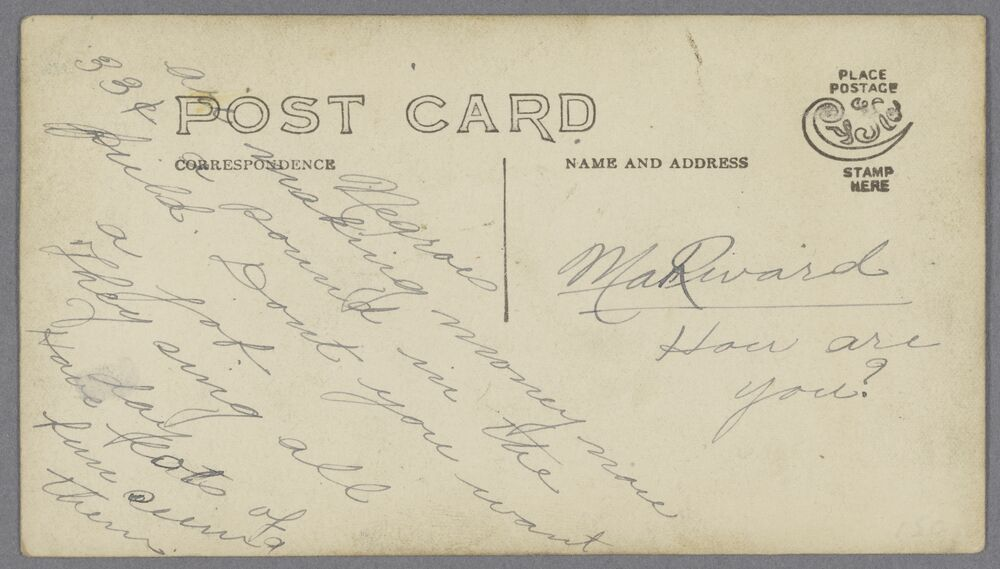

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))

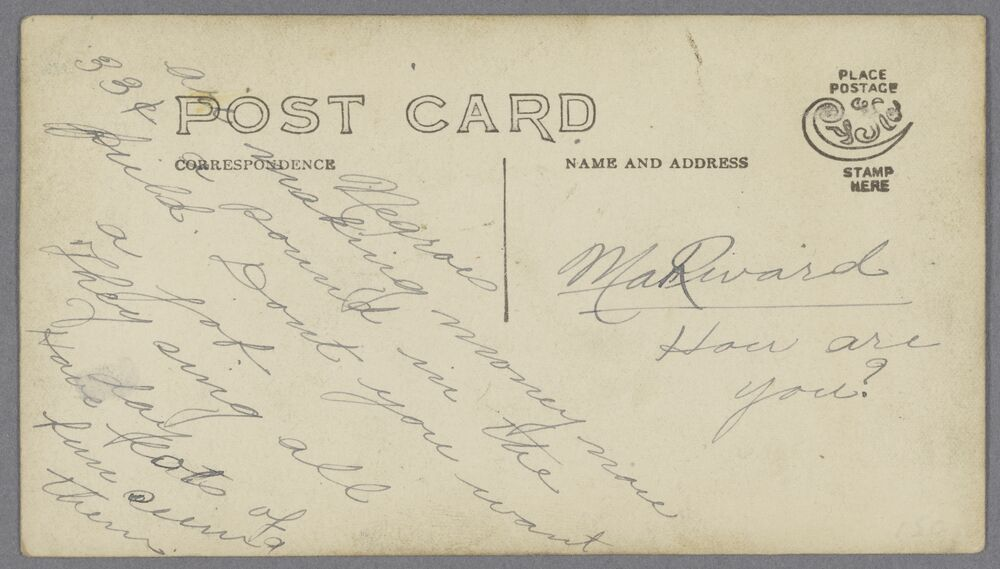

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))

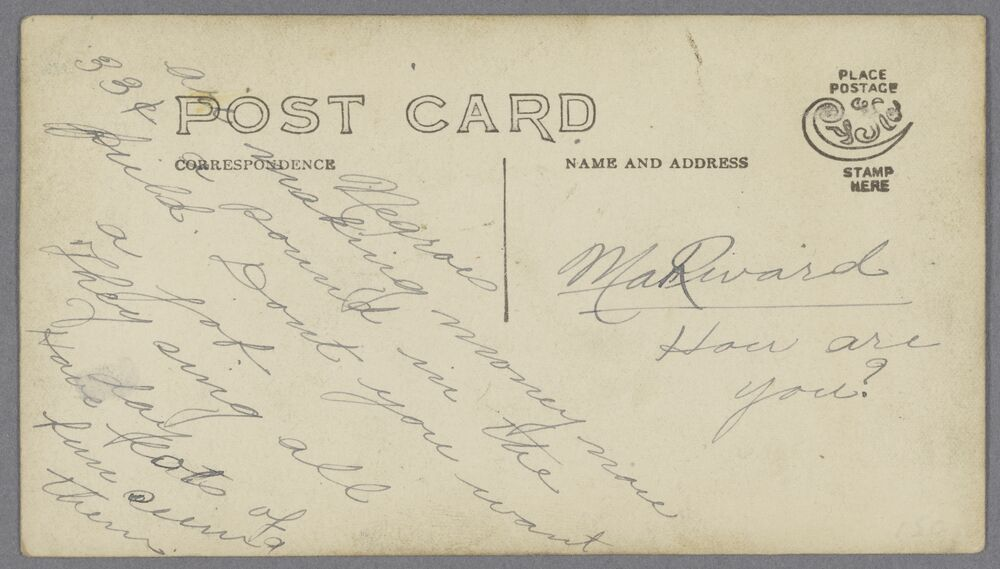

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))

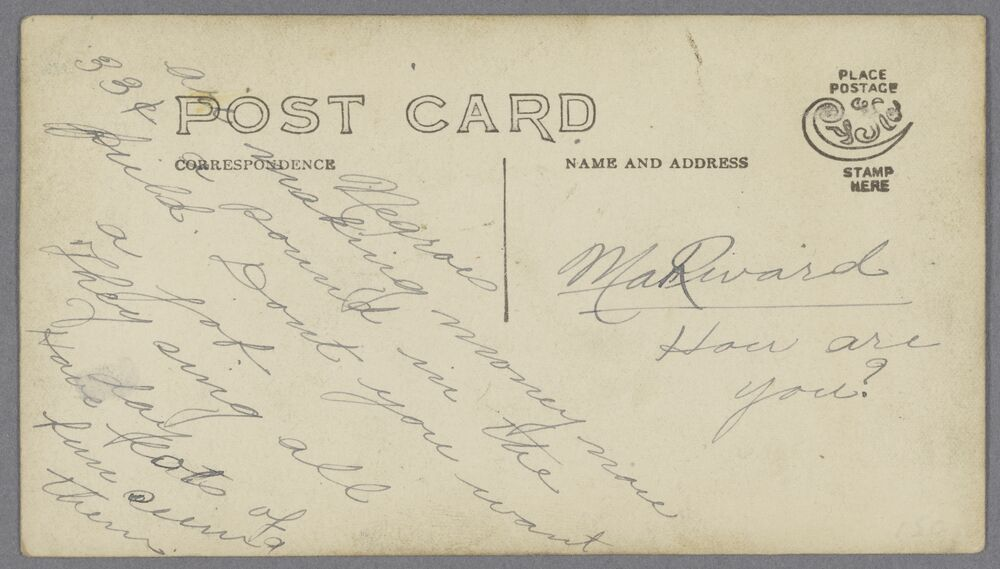

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))

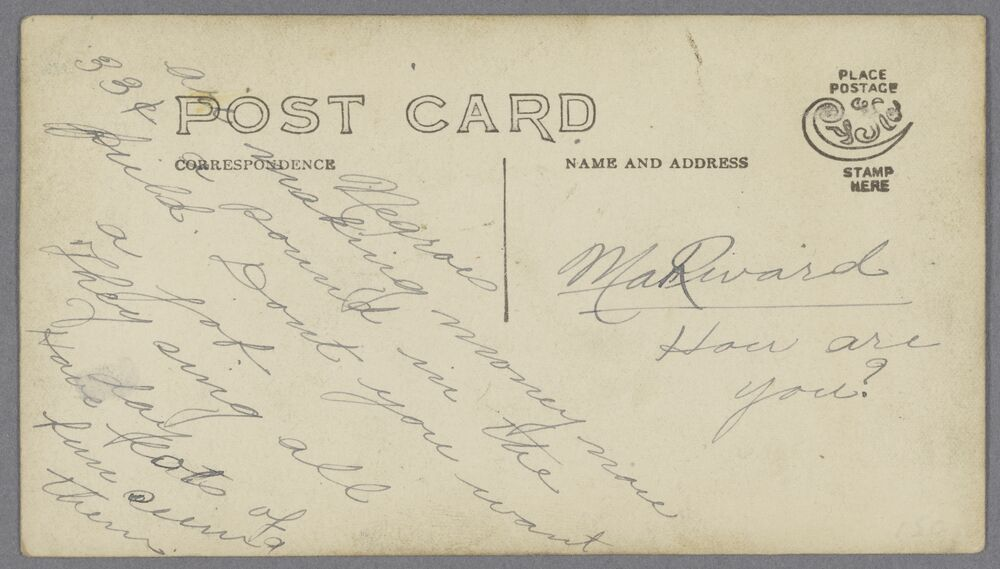

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))

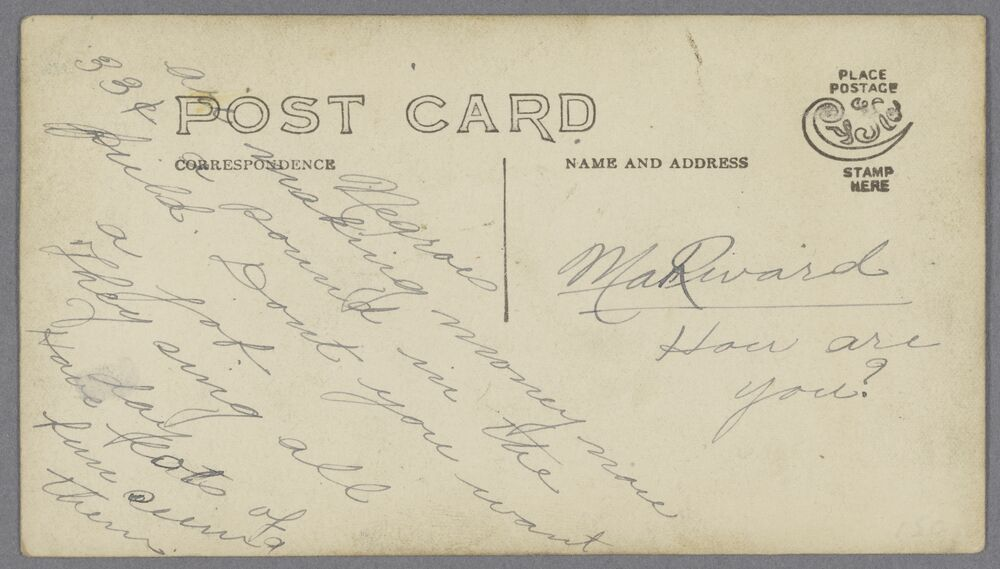

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))

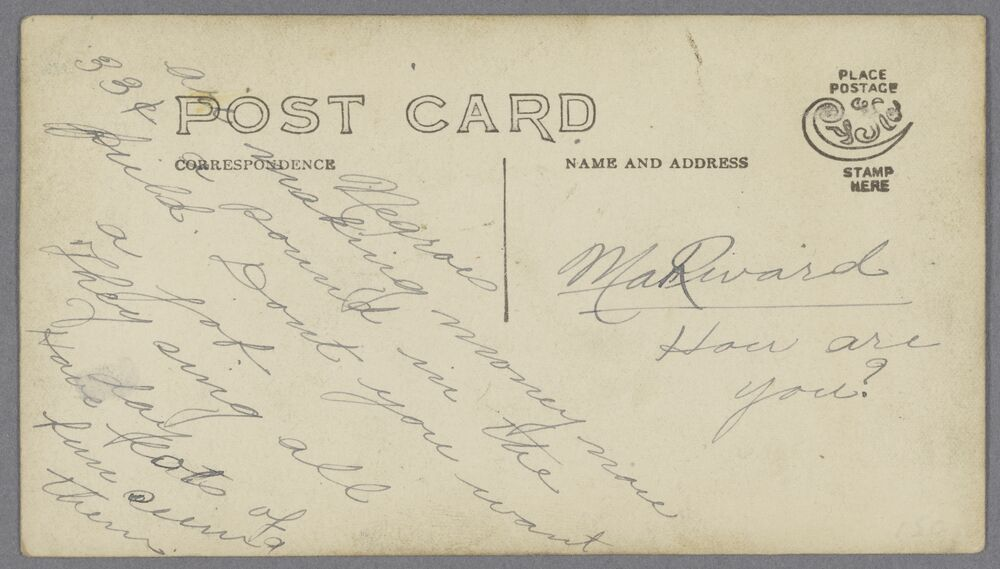

In [ ]:

from pathlib import Path
from PIL import Image
img_path = f"{image_path}/{work_id}_back.jpg"
# display the image in the notebook
if Path(img_path).exists():
    display(Image.open(img_path))